# Filter Designer

### Introduction

In signal processing, a digital biquad filter is a second order recursive linear filter, containing two poles and two zeros. "Biquad" is an abbreviation of "biquadratic", which refers to the fact that in the Z domain, its transfer function is the ratio of two quadratic functions:

$$\begin{align}
H(z)={\frac {b_{0}+b_{1}z^{{-1}}+b_{2}z^{{-2}}}{a_{0}+a_{1}z^{{-1}}+a_{2}z^{{-2}}}}
\end{align}$$

The coefficients are often normalized such that $a_{0} = 1$:

$$\begin{align} 
H(z)={\frac {b_{0}+b_{1}z^{{-1}}+b_{2}z^{{-2}}}{1+a_{1}z^{{-1}}+a_{2}z^{{-2}}}}
\end{align}$$

High-order IIR filters can be highly sensitive to quantization of their coefficients, and can easily become unstable. This is much less of a problem with first and second-order filters; therefore, higher-order filters are typically implemented as serially-cascaded biquad sections (and a first-order filter if necessary). The two poles of the biquad filter must be inside the unit circle for it to be stable. In general, this is true for all discrete filters i.e. all poles must be inside the unit circle in the Z-domain for the filter to be stable. 

### Direct form

<img align="center" width=50% src="biquad.png" alt>

In [1]:
import math
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

EULER = np.exp(1)

In [2]:
def refresh(func):
    def dummy_function(instance, *args):
        func(instance, *args)
        instance.coefGenerator()
    return dummy_function
    
class IIRCoefDesigner():

    def __init__(self, filter_type: str = 'flat', frequency_cut: float = 1200, sample_rate: float = 44100,
                 Q: float = 0.707, slope: float = 0, magnitude: float = 0):

        self._filter_type = filter_type
        self._freq = frequency_cut
        self._sr = sample_rate
        self._q = Q
        self._slope = slope
        self._magnitude = magnitude

        self.initCoef()
        self.coefGenerator()

    def initCoef(self):
        self.a0, self.a1, self.a2, self.b0, self.b1, self.b2 = 0, 0, 0, 0, 0, 0

    @property
    def omega(self):
        return (2 * math.pi * self.freq / self.sr)

    @property
    def gain(self):
        return pow(10, (self.magnitude / 20))

    @property
    def sineOmega(self):
        return np.sin(self.omega)

    @property
    def cosineOmega(self):
        return np.cos(self.omega)

    @property
    def filter_type(self):
        return self._filter_type

    @filter_type.setter
    @refresh
    def filter_type(self, input_data):
        self._filter_type = input_data

    @property
    def freq(self):
        return self._freq

    @freq.setter
    @refresh
    def freq(self, input_data):
        self._freq = input_data

    @property
    def sr(self):
        return self._sr

    @sr.setter
    @refresh
    def sr(self, input_data):
        self._sr = input_data

    @property
    def q(self):
        return self._q

    @q.setter
    @refresh
    def q(self, input_data):
        self._q = input_data

    @property
    def slope(self):
        return self._slope

    @slope.setter
    @refresh
    def slope(self, input_data):
        if (input_data >= 2.0):
            self._slope = 2.0
        elif (input_data <= 0.1):
            self._slope = 0.1
        else:
            self._slope = input_data

    @property
    def magnitude(self):
        return self._magnitude

    @magnitude.setter
    @refresh
    def magnitude(self, input_data):
        self._magnitude = input_data

    def coefGenerator(self):

        filter_type = self.filter_type

        if filter_type == 'flat':
            self.b0 = 1.0
            self.b1 = 0.0
            self.b2 = 0.0

            self.a1 = 0.0
            self.a2 = 0.0

        elif filter_type == 'low-pass1':
            self.a1 = pow(EULER, -self.omega)

            self.b0 = (1.0 - self.a1) * self.gain
            self.b1 = 0.0
            self.b2 = 0.0

            self.a1 = -self.a1
            self.a2 = 0.0

        elif filter_type == 'high-pass1':
            self.a1 = pow(EULER, -self.omega)

            self.b0 = (1.0 + self.a1) * self.gain / 2
            self.b1 = -(1.0 + self.a1) * self.gain / 2
            self.b2 = 0.0

            self.a1 = -self.a1
            self.a2 = 0.0

        elif filter_type == 'all-pass1':
            self.a1 = pow(EULER, -self.omega)

            self.b0 = -self.a1 * self.gain
            self.b1 = self.gain
            self.b2 = 0.0

            self.a1 = -self.a1
            self.a2 = 0.0

        elif filter_type == 'low-pass2':
            alpha = self.sineOmega / (2 * self.q)

            self.a0 = 1 + alpha
            self.a1 = (-2 * self.cosineOmega) / self.a0
            self.a2 = (1 - alpha) / self.a0

            self.b0 = (1 - self.cosineOmega) * self.gain / 2 / self.a0
            self.b1 = (1 - self.cosineOmega) * self.gain / self.a0
            self.b2 = (1 - self.cosineOmega) * self.gain / 2 / self.a0

        elif filter_type == 'high-pass2':
            alpha = self.sineOmega / (2 * self.q)

            self.a0 = 1 + alpha
            self.a1 = (-2 * self.cosineOmega) / self.a0
            self.a2 = (1 - alpha) / self.a0

            self.b0 = (1 + self.cosineOmega) * self.gain / 2 / self.a0
            self.b1 = -(1 + self.cosineOmega) * self.gain / self.a0
            self.b2 = (1 + self.cosineOmega) * self.gain / 2 / self.a0

        elif filter_type == 'all-pass2':
            alpha = self.sineOmega / (2 * self.q)

            self.a0 = 1 + alpha
            self.a1 = (-2 * self.cosineOmega) / self.a0
            self.a2 = (1 - alpha) / self.a0

            self.b0 = (1 - alpha) * self.gain / self.a0
            self.b1 = (-2 * self.cosineOmega) * self.gain / self.a0
            self.b2 = (1 + alpha) * self.gain / self.a0

        elif filter_type == 'parametric':
            A = pow(10.0, (self.magnitude / 40.0))
            alpha = self.sineOmega / (2 * A * self.q)

            self.a0 = 1 + alpha / A
            self.a1 = (-2 * self.cosineOmega) / self.a0
            self.a2 = (1 - alpha / A) / self.a0

            self.b0 = (1 + alpha * A) / self.a0
            self.b1 = -(2 * self.cosineOmega) / self.a0
            self.b2 = (1 - alpha * A) / self.a0

        elif filter_type == 'peaking':
            V0 = pow(10.0, abs(self.magnitude) / 20.0)
            
            K = self.sineOmega / (1 + self.cosineOmega)
            KK = K * K
            Rac2 = np.sqrt(2)
            KsQinf = K / self.q;
            
            if self.magnitude >=0:
                self.a0 = 1.0 + KsQinf + KK;
                self.b0 = (1.0 + V0 * KsQinf + KK) / self.a0;
                self.b1 = 2.0 * (KK - 1.0) / self.a0;
                self.b2 = (1.0 - V0 * KsQinf + KK) / self.a0;
                self.a1 = self.b1;
                self.a2 = (1.0 - KsQinf + KK) / self.a0;
            else:
                self.a0 = 1.0 + V0 * KsQinf + KK;
                self.b0 = (1.0 + KsQinf + KK) / self.a0;
                self.b1 = 2.0 * (KK - 1.0) / self.a0;
                self.b2 = (1.0 - KsQinf + KK) / self.a0;
                self.a1 = self.b1;
                self.a2 = (1.0 - V0 * KsQinf + KK) / self.a0;

        elif filter_type == 'band-pass':
            alpha = self.sineOmega / (2 * self.q)

            self.a0 = 1 + alpha
            self.a1 = (-2.0 * self.cosineOmega) / self.a0
            self.a2 = (1 - alpha) / self.a0

            self.b0 = (alpha * self.gain) / self.a0
            self.b1 = 0.0
            self.b2 = -(alpha * self.gain) / self.a0

        elif filter_type == 'notch':
            alpha = self.sineOmega / (2 * self.q)

            self.a0 = 1 + alpha
            self.a1 = (-2.0 * self.cosineOmega) / self.a0
            self.a2 = (1.0 - alpha) / self.a0

            self.b0 = self.gain / self.a0
            self.b1 = (-2.0 * self.cosineOmega * self.gain) / self.a0
            self.b2 = self.gain / self.a0

        elif filter_type == 'low-shelf':
            A = pow(10.0, (self.magnitude / 40.0))
            alpha = self.sineOmega / 2 * np.sqrt((A + 1 / A) * (1 / self.slope - 1) + 2)

            self.a0 = (A + 1) + (A - 1) * self.cosineOmega + 2 * np.sqrt(A) * alpha
            self.a1 = (-2 * ((A - 1) + (A + 1) * self.cosineOmega)) / self.a0
            self.a2 = ((A + 1) + (A - 1) * self.cosineOmega - 2 * np.sqrt(A) * alpha) / self.a0

            self.b0 = (A * ((A + 1) - (A - 1) * self.cosineOmega + 2 * np.sqrt(A) * alpha)) / self.a0
            self.b1 = (2 * A * ((A - 1) - (A + 1) * self.cosineOmega)) / self.a0
            self.b2 = (A * ((A + 1) - (A - 1) * self.cosineOmega - 2 * np.sqrt(A) * alpha)) / self.a0

        elif filter_type == 'high-shelf':
            A = pow(10.0, (self.magnitude / 40.0))
            alpha = self.sineOmega / 2 * np.sqrt((A + 1 / A) * (1 / self.slope - 1) + 2)

            self.a0 = (A + 1) - (A - 1) * self.cosineOmega + 2 * np.sqrt(A) * alpha
            self.a1 = (2 * ((A - 1) - (A + 1) * self.cosineOmega)) / self.a0
            self.a2 = ((A + 1) - (A - 1) * self.cosineOmega - 2 * np.sqrt(A) * alpha) / self.a0

            self.b0 = (A * ((A + 1) + (A - 1) * self.cosineOmega + 2 * np.sqrt(A) * alpha)) / self.a0
            self.b1 = (-2 * A * ((A - 1) + (A + 1) * self.cosineOmega)) / self.a0
            self.b2 = (A * ((A + 1) + (A - 1) * self.cosineOmega - 2 * np.sqrt(A) * alpha)) / self.a0
        
        elif filter_type == 'low-shelve':
            V0 = pow(10.0, abs(self.magnitude) / 20.0)
            
            K = self.sineOmega / (1 + self.cosineOmega)
            KK = K * K
            Rac2 = math.sqrt(2)
            
            if self.magnitude >=0:
                self.a0 = 1.0 + Rac2 * K + KK 
                self.a1 = 2.0 * (KK - 1.0) / self.a0
                self.a2 = (1.0 - Rac2 * K + KK) / self.a0
                
                self.b0 = (1.0 + np.sqrt(2.0 * V0) * K + V0 * KK) / self.a0
                self.b1 = 2.0 * (V0 * KK - 1.0) / self.a0
                self.b2 = (1.0 - np.sqrt(2.0 * V0) * K + V0 * KK) / self.a0
            else:
                self.a0 = (1.0 + sqrt(2.0 * V0) * K + V0 * KK);
                self.a1 = 2.0 * (V0 * KK - 1.0) / self.a0
                self.a2 = (1.0 - np.sqrt(2.0 * V0) * K + V0 * KK) / self.a0
                
                self.b0 = (1.0 + Rac2 * K + KK) / self.a0 
                self.b1 = 2.0 * (KK - 1.0) / self.a0
                self.b2 = (1.0 - Rac2 * K + KK) / self.a0
                
        elif filter_type == 'high-shelve':
            V0 = pow(10.0, abs(self.magnitude) / 20.0)
            
            K = self.sineOmega / (1 + self.cosineOmega)
            KK = K * K
            Rac2 = math.sqrt(2)
            
            if self.magnitude >=0:
                self.a0 = 1.0 + Rac2 * K + KK;
                self.b0 = (V0 + np.sqrt(2.0 * V0) * K + KK) / self.a0;
                self.b1 = 2.0 * (KK - V0) / self.a0;
                self.b2 = (V0 - np.sqrt(2.0 * V0) * K + KK) / self.a0;
                self.a1 = 2.0 * (KK - 1.0) / self.a0;
                self.a2 = (1.0 - Rac2 * K + KK) / self.a0;
            else:
                self.a0 = (V0 + np.sqrt(2.0 * V0) * K + KK);
                self.b0 = (1.0 + Rac2 * K + KK) / self.a0;
                self.b1 = 2.0 * (KK - 1.0) / self.a0;
                self.b2 = (1.0 - Rac2 * K + KK) / self.a0;
                self.a0 = (1.0 + np.sqrt(2.0 / V0) * K + KK / V0);
                self.a1 = 2.0 * (KK / V0 - 1.0) / self.a0;
                self.a2 = (1.0 - np.sqrt(2.0 / V0) * K + KK / V0) / self.a0;

    def coef(self):
        self.a0 = 1.0
        self._coef = {'a': [], 'b': []}
        self._coef['a'] = [self.a0, self.a1, self.a2]
        self._coef['b'] = [self.b0, self.b1, self.b2]
        return self._coef

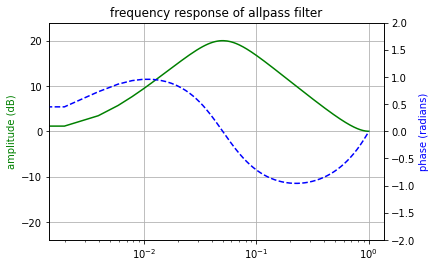

In [3]:
filter_instance = IIRCoefDesigner(filter_type= 'peaking', frequency_cut=1200, sample_rate=48000, Q=0.707, slope=0, magnitude=20)
numerator = filter_instance.coef()['b']
denominator = filter_instance.coef()['a']

w, h = signal.freqz(numerator, denominator)
amplitude = 20 * np.log10(abs(h))
angle = np.angle(h)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('frequency response of allpass filter')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-24, 24)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')
ax2.set_ylim(-2, 2)

plt.xscale("log")
plt.show()